# Extreme Driving Detection

Extreme turning movement detection (outliers detection)

In [3]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor as LOF
%matplotlib inline
# %matplotlib widget

In [100]:
# load the dataset
df = pd.read_csv("all_LAT_uns.csv")

#print first 10 rows and descriptive statistics
df.head(10)

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed
0,0.001,-0.002,-0.007,0.002,-0.001,0.000,0.0
1,0.007,0.000,0.011,-0.001,0.001,0.000,0.0
2,0.008,0.004,0.015,0.000,0.000,-0.001,0.0
3,0.008,0.002,0.004,0.002,-0.001,-0.001,0.0
4,0.009,0.001,0.026,-0.002,-0.001,0.002,0.0
5,0.012,-0.001,0.003,0.000,0.000,-0.001,0.0
6,0.007,0.000,0.004,-0.001,0.000,0.000,0.0
7,-0.008,-0.006,0.002,0.001,-0.001,0.000,0.0
8,-0.004,0.005,0.022,0.000,0.001,0.001,0.0
9,0.007,0.007,0.016,0.000,-0.002,0.003,0.0


In [101]:
df.describe()

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed
count,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000,103891.000000
mean,-0.000079,0.000867,0.009910,-0.000357,-0.000180,0.000291,16.333149
std,0.058077,0.060980,0.063359,0.134682,0.128994,0.146620,12.691258
min,-1.322000,-2.163000,-1.415000,-9.102000,-12.628000,-13.615000,0.000000
25%,-0.022000,-0.022000,-0.015000,-0.013000,-0.013000,-0.010000,6.040000
50%,0.000000,0.001000,0.011000,0.000000,0.000000,0.000000,13.080000
75%,0.022000,0.024000,0.035000,0.013000,0.013000,0.010000,29.000000
max,1.224000,1.033000,1.185000,7.147000,7.212000,6.953000,47.660000


In [102]:
#create new feature 
# new single feature calculation
df['T'] = (1/9.81)*np.sqrt((df.loc[:, 'NewRotRateZ']**2)*(df.loc[:, 'locationSpeed'])**2 + (df.loc[:, 'NewAccelX']**2))
df['T'].describe()

count    103891.000000
mean          0.048497
std           0.162435
min           0.000000
25%           0.005215
50%           0.016315
75%           0.046902
max          13.287318
Name: T, dtype: float64

In [103]:
# function for visualizing results of outlier detection
def outlier_vis(var1, var2, var3, df, method):
    ''' arguments: df - the dataframe that should contain a column inicating if each row is an outlier
                    var1, var2, var3 - the variables to visualize
                    method - name of method whose outliers are visualized (column that contains the outliers label)'''
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    
    # plot normal data
    ax.scatter(df[df[method]==0][var1], df[df[method]==0][var2], df[df[method]==0][var3], color = "b", s=3)
    # plot outlier values
    ax.scatter(df[df[method]==1][var1], df[df[method]==1][var2], df[df[method]==1][var3], color = "r", s=3)
    
    ax.set_xlabel(var2)
    ax.set_ylabel(var1)
    ax.set_zlabel(var3)
    
    fig.show()
    
                

## Box plot

### Variable: T

In [108]:
# Example based on variable T
q1 = df['T'].quantile(0.25)
q3 = df['T'].quantile(0.75)
iqr = q3-q1
print("IQR =",iqr)

IQR = 0.041687122944857234


Number of detected outliers: 11028


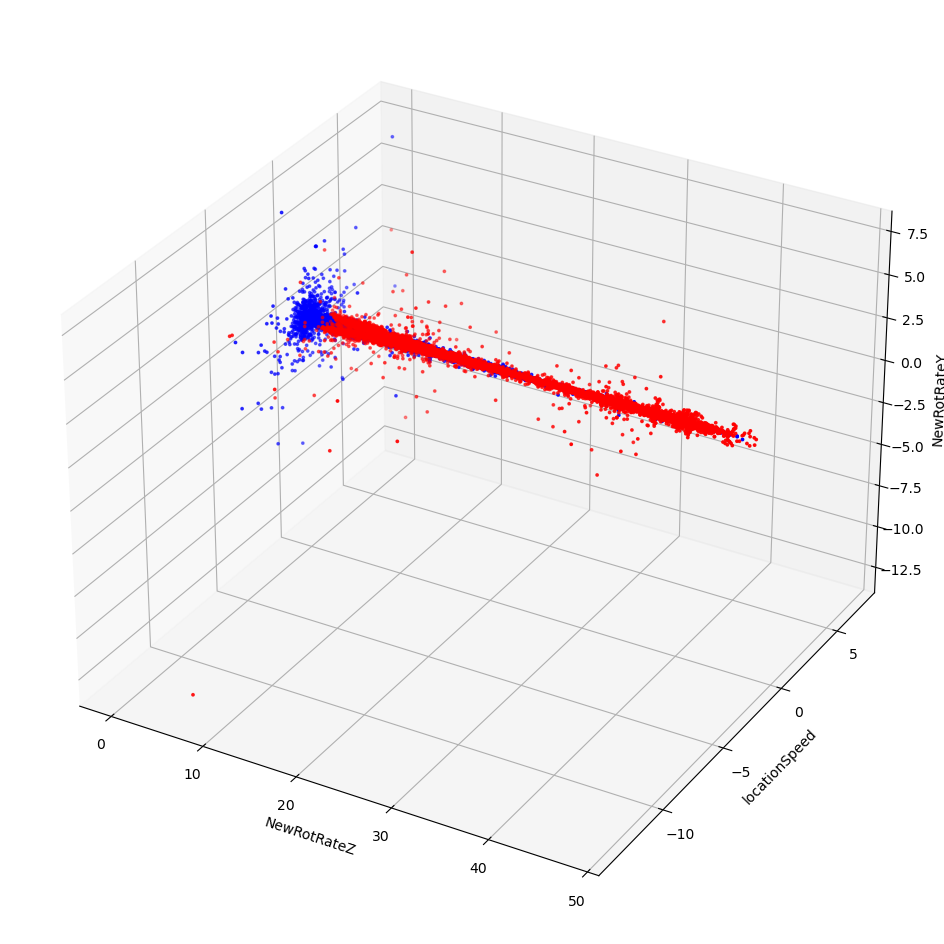

In [109]:
# create a new column with value 1 for outliers and 0 for the rest
df['bplot_T'] = ((df['T']<q1-1.5*iqr) | (df['T']>q3+1.5*iqr))

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'bplot_T') #experiment with other columns as well

print("Number of detected outliers:", df['bplot_T'].sum())

### Variable: NewAccelX

In [110]:
# Example based on variable T
q1 = df['NewAccelX'].quantile(0.25)
q3 = df['NewAccelX'].quantile(0.75)
iqr = q3-q1
print("IQR =",iqr)

IQR = 0.044


Number of detected outliers: 8655


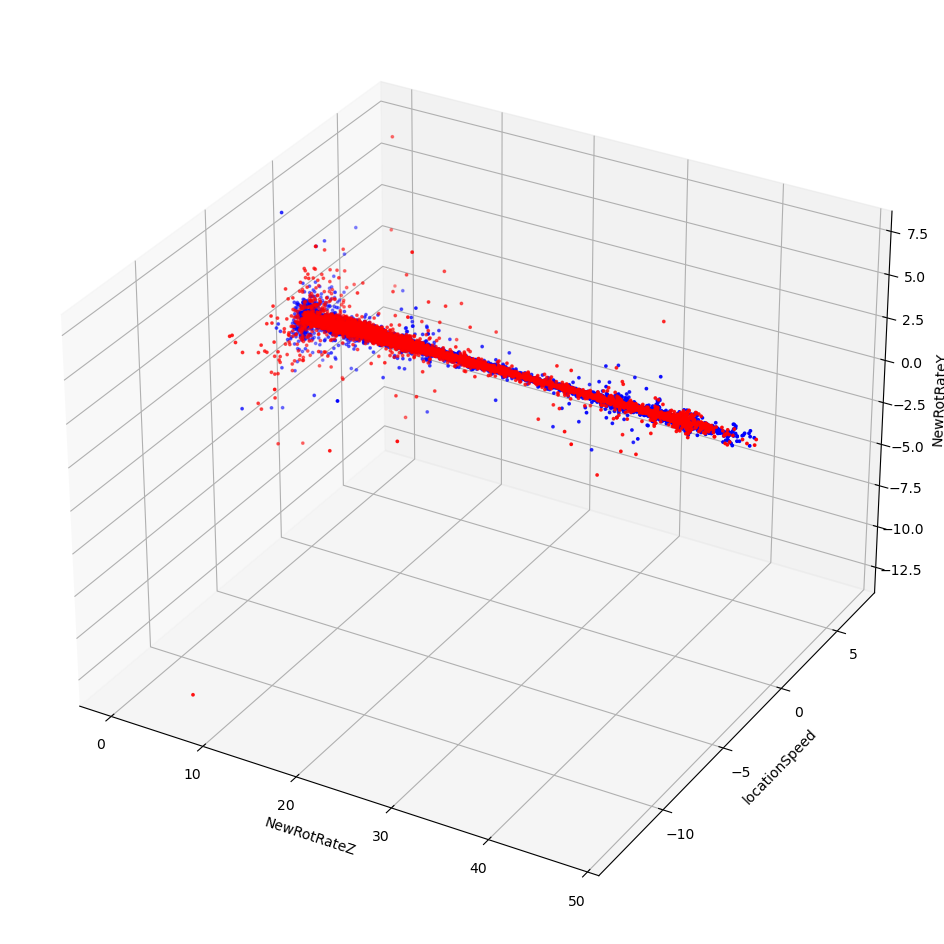

In [111]:
# create a new column with value 1 for outliers and 0 for the rest
df['bplot_NewAccelX'] = ((df['NewAccelX']<q1-1.5*iqr) | (df['NewAccelX']>q3+1.5*iqr))

# call the function for visualizing
outlier_vis('locationSpeed', 'NewRotRateZ', 'NewRotRateY', df,'bplot_NewAccelX')

print("Number of detected outliers:", df['bplot_NewAccelX'].sum())

## Z-score

### Variable: T

In [112]:
# calculate the Z-score for "T"
mean = df['T'].mean()
std_dev = df['T'].std()
df['Z-score_T'] = abs(df['T']-mean)/std_dev

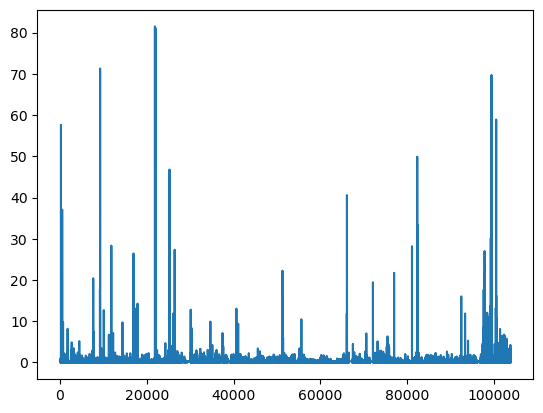

In [113]:
# plot the Z-score values in order to intuitively (visually) choose a proper threshold
plt.plot(df['Z-score_T'])
plt.show()

In [114]:
# programmatically define a good threshold value so that 0.5% of the values are outliers

outliers_number = int(len(df) * 0.5/100)
min_distance = np.inf

for threshold in np.arange(1.5, 10, 0.25):
    # select threshold so that 0.5% are outliers
    outliers_found = (df['Z-score_T'] > threshold).sum()
    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_threshold = threshold

Number of detected outliers: 514


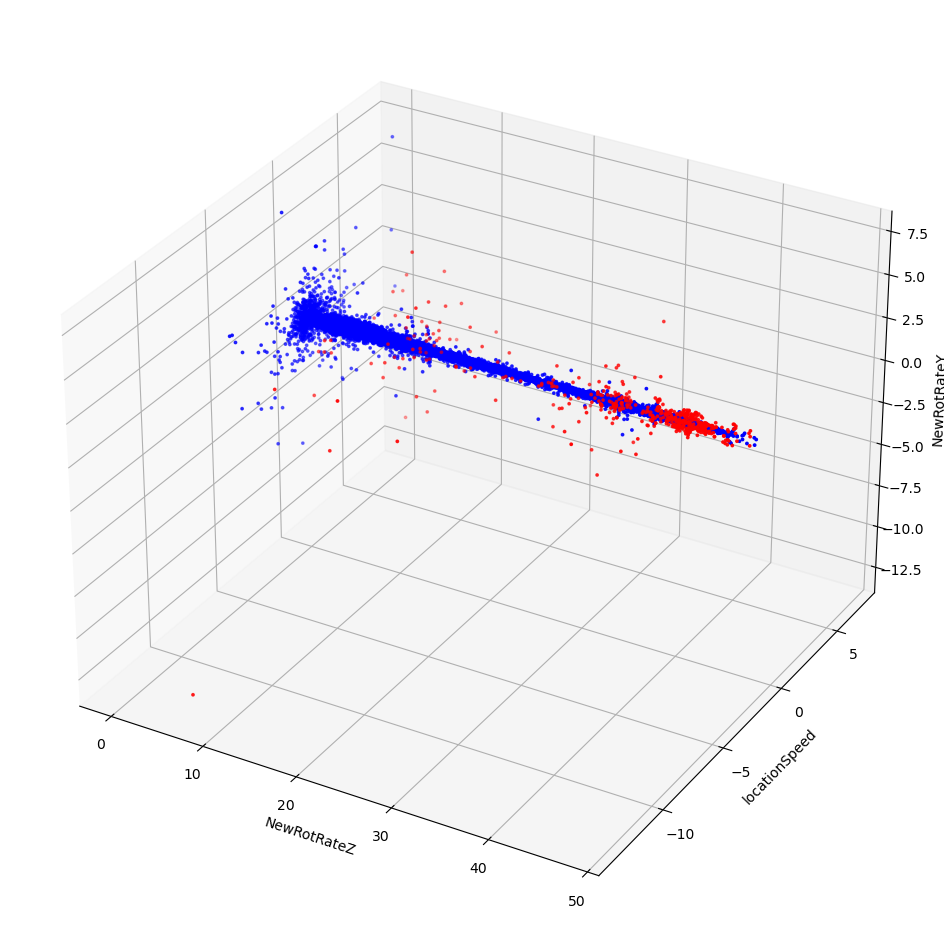

In [115]:

# create a new column with value 1 for outliers and 0 for the rest
df['zscore_T'] = df['Z-score_T'] > final_threshold

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'zscore_T')

print("Number of detected outliers:", df['zscore_T'].sum())


### Variable: NewAccelX

In [116]:
# calculate the Z-score for "T"
mean = df['NewAccelX'].mean()
std_dev = df['NewAccelX'].std()
df['Z-score_NewAccelX'] = abs(df['NewAccelX']-mean)/std_dev

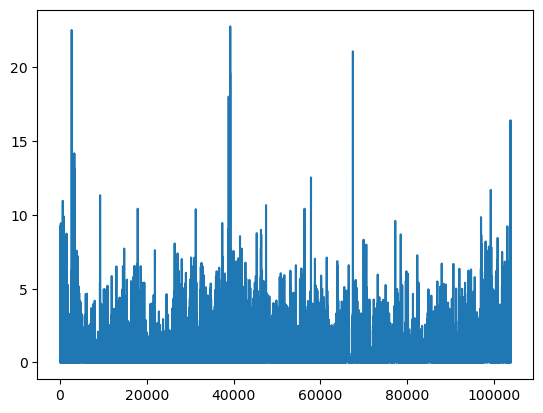

In [117]:
# plot the Z-score values in order to intuitively (visually) choose a proper threshold
plt.plot(df['Z-score_NewAccelX'])
plt.show()

In [118]:
# programmatically define a good threshold value so that 0.5% of the values are outliers

outliers_number = int(len(df) * 0.5/100)
min_distance = np.inf

for threshold in np.arange(1.5, 12, 0.25):
    # select threshold so that 0.5% are outliers
    outliers_found = (df['Z-score_NewAccelX'] > threshold).sum()
    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_threshold = threshold

Number of detected outliers: 546


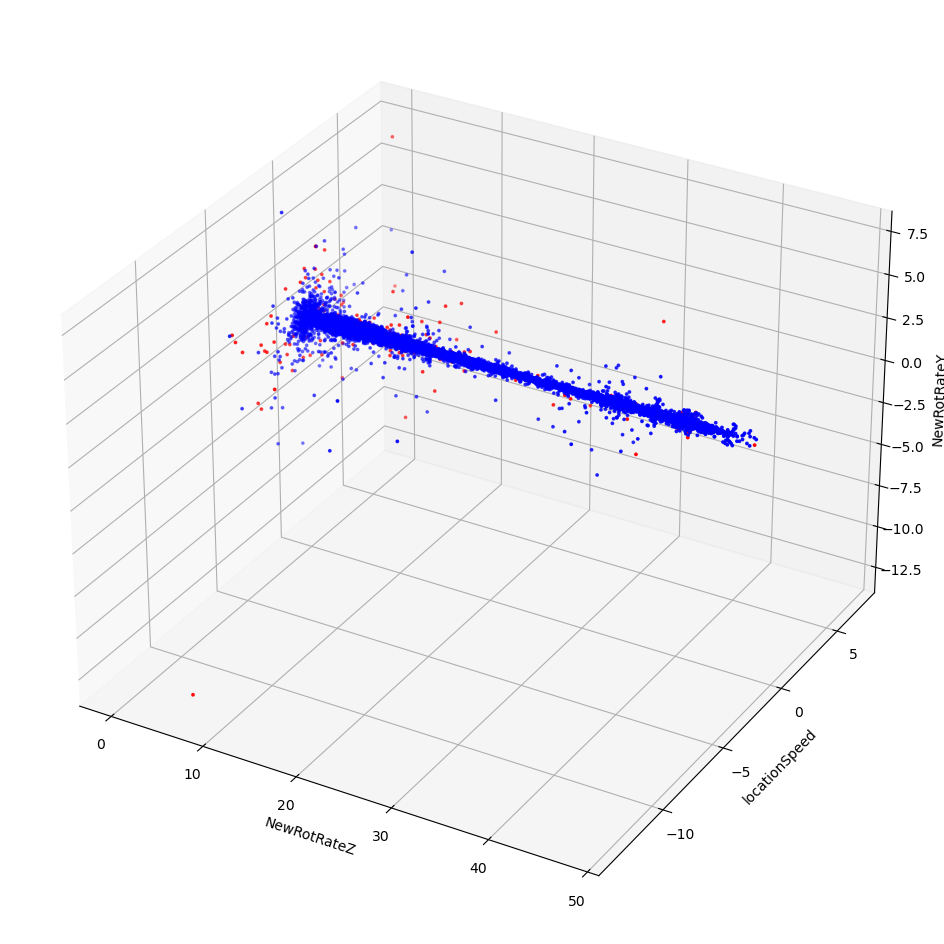

In [119]:

# create a new column with value 1 for outliers and 0 for the rest
df['zscore_NewAccelX'] = df['Z-score_NewAccelX'] > final_threshold

# call the function for visualizing
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'zscore_NewAccelX')

print("Number of detected outliers:", df['zscore_NewAccelX'].sum())


## kNN

In [127]:
# instantiate model
knn = NearestNeighbors(n_neighbors = 3)
# fit model
x = df[['NewAccelX', 'NewRotRateZ', 'T']] # use only relevant columns
knn.fit(x)

# get distances
dist, _ = knn.kneighbors(x)

# save mean value of distances in df
df['mean_dist_knn'] = dist.mean(axis=1)

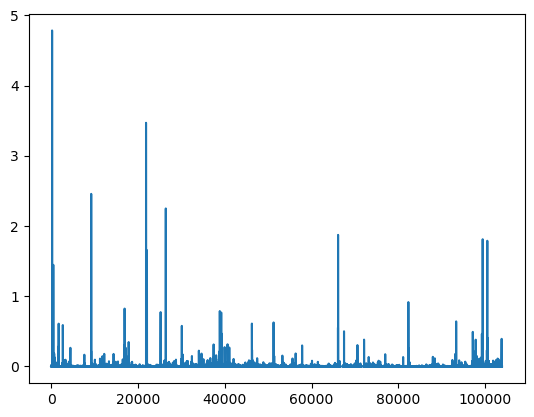

In [129]:
# plot in order to visually choose a threshold
plt.plot(df['mean_dist_knn'])
plt.show()

In [136]:
final_threshold

0.05

In [139]:
# programmatically define a good threshold value so that 0.5% of the values are outliers

outliers_number = int(len(df) * 0.5/100)
min_distance = np.inf

for threshold in np.arange(0, 1, 0.005):
    # select threshold so that 0.5% are outliers
    outliers_found = (df['mean_dist_knn'] > threshold).sum()
    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_threshold = threshold

Number of detected outliers: 535


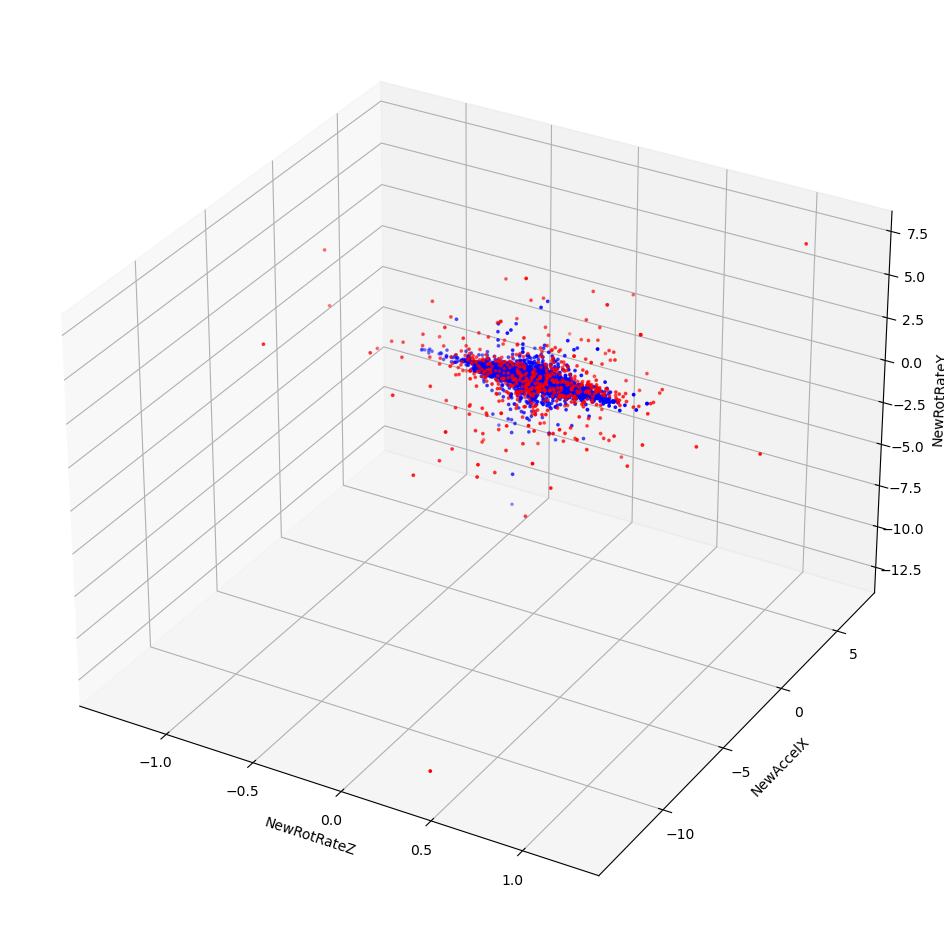

In [145]:
# create a new column with value 1 for outliers and 0 for the rest
df['knn'] = df['mean_dist_knn'] > final_threshold

# call the function for visualizing
outlier_vis('NewAccelX','NewRotRateZ', 'NewRotRateY', df,'knn')

print("Number of detected outliers:", df['knn'].sum())

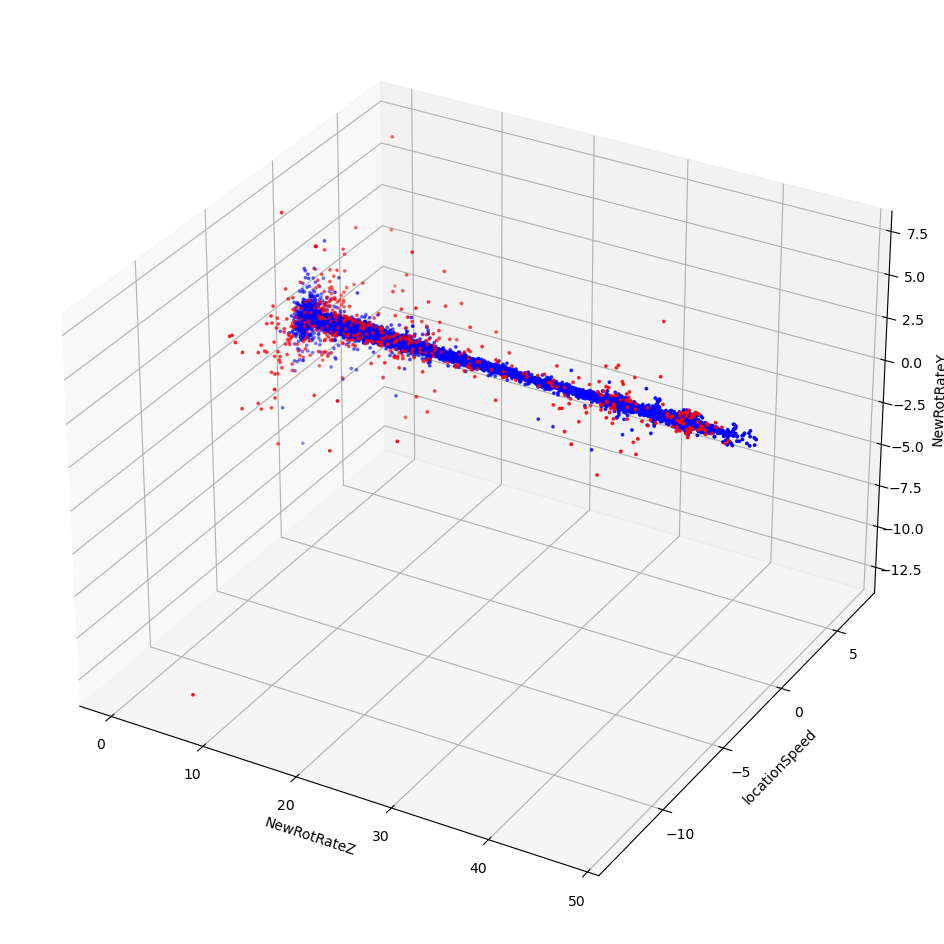

In [144]:
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'knn')


## Local Outlier Factor (LOF)

In [146]:
df.head()

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed,T,bplot_T,bplot_NewAccelX,Z-score_T,zscore_T,Z-score_NewAccelX,zscore_NewAccelX,mean_dist_knn,knn
0,0.001,-0.002,-0.007,0.002,-0.001,0.000,0.0,0.000102,False,False,0.297934,False,0.018578,False,0.0,False
1,0.007,0.000,0.011,-0.001,0.001,0.000,0.0,0.000714,False,False,0.294169,False,0.121889,False,0.0,False
2,0.008,0.004,0.015,0.000,0.000,-0.001,0.0,0.000815,False,False,0.293541,False,0.139107,False,0.0,False
3,0.008,0.002,0.004,0.002,-0.001,-0.001,0.0,0.000815,False,False,0.293541,False,0.139107,False,0.0,False
4,0.009,0.001,0.026,-0.002,-0.001,0.002,0.0,0.000917,False,False,0.292913,False,0.156326,False,0.0,False


In [167]:
# again assume about 0.5% of the dataset records to be outliers
min_distance = np.inf

for neighbors in range(2, 20):
    # select neighbors so that about 0.5% are outliers

    # instantiate model
    lof = LOF(n_neighbors=neighbors)

    # fit model and detect outliers (LOF library returns -1 for outliers and 1 for other data)
    lof_outliers = lof.fit_predict(x)

    # similarly to the other methods, we convert to 1 for outliers and 0 for the rest of the data
    outliers_found = (lof_outliers == -1).sum()

    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_neighbors = neighbors

    

lof = LOF(n_neighbors=final_neighbors)
lof_outliers = lof.fit_predict(x)
df['lof'] = (lof_outliers==-1)

Number of detected outliers: 1866


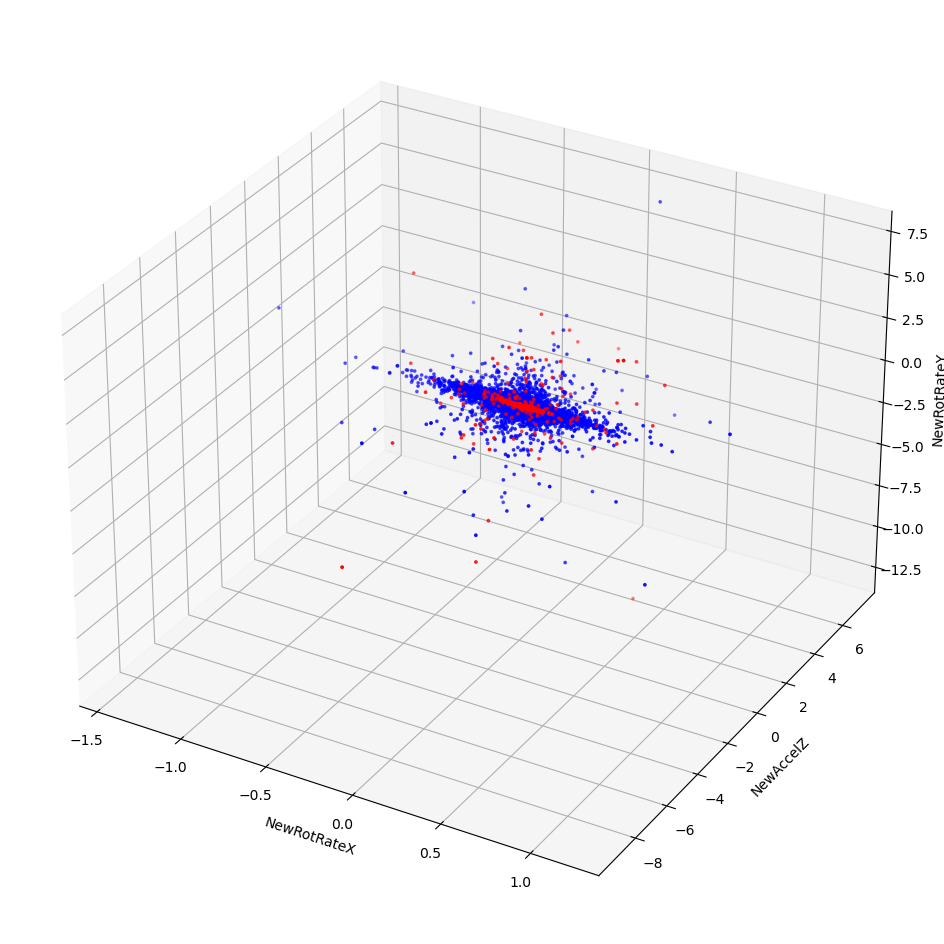

In [171]:
# call the function for visualizing
outlier_vis('NewAccelZ','NewRotRateX', 'NewRotRateY', df,'lof')

print("Number of detected outliers:", df['lof'].sum())

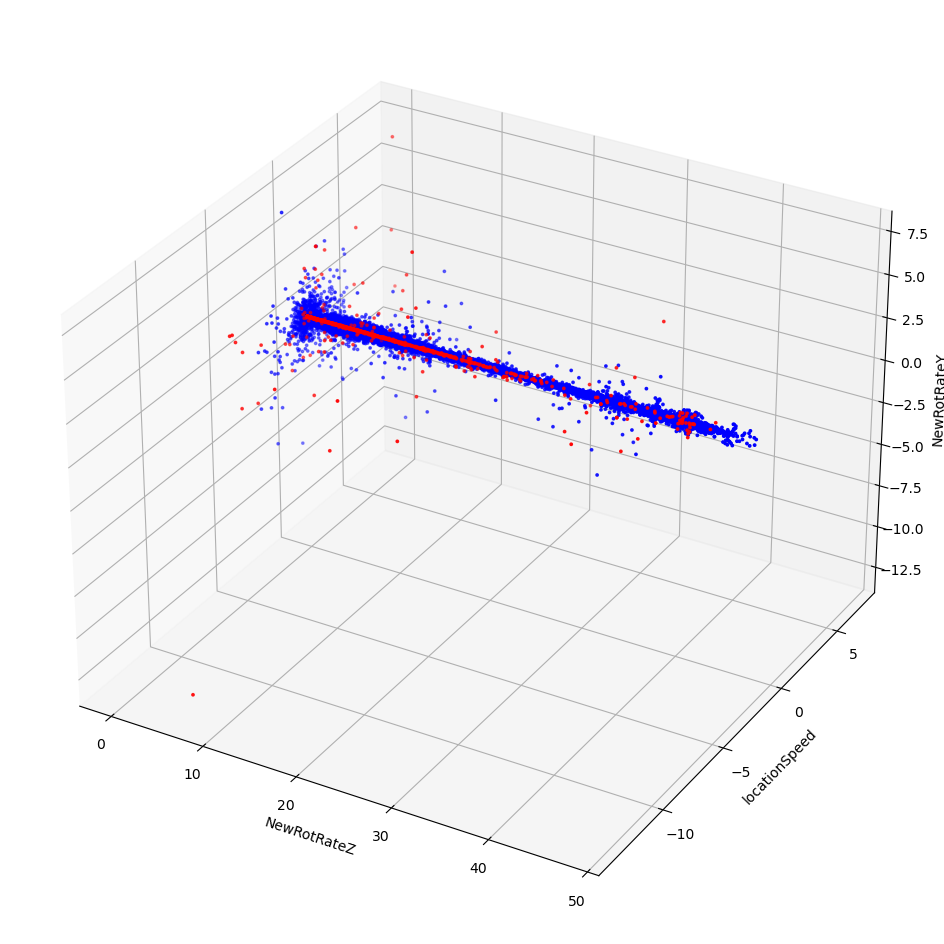

In [172]:
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df,'lof')


## Isolation Forest

In [214]:
from sklearn.ensemble import IsolationForest

# again assume about 0.5% of the dataset records to be outliers
min_distance = np.inf

for contamination in np.arange(0.0025, 0.5, 0.0025):
    # select contamination so that about 0.5% are outliers

    # instantiate model
    isol_forest = IsolationForest(n_estimators=100, contamination=contamination)

    # fit model and detect outliers (isolation forest returns -1 for outliers and 1 for other data)
    isolation_forest_outliers = isol_forest.fit_predict(x.to_numpy())

    # similarly to the other methods, we convert to 1 for outliers and 0 for the rest of the data
    outliers_found = (isolation_forest_outliers == -1).sum()

    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_outliers = (isolation_forest_outliers == -1)
        final_contamination = contamination
    else:
        # since we traverse the contamination values sequentially from smaller to larger, we are increasing
        # the number of outliers in every iteration. Initially the distance is getting lower, until a point
        # where outliers increase over the 0.5% of the dataset records and we can exit the loop early for
        # better computational performance, skipping some iterations
        break

Number of detected outliers: 520


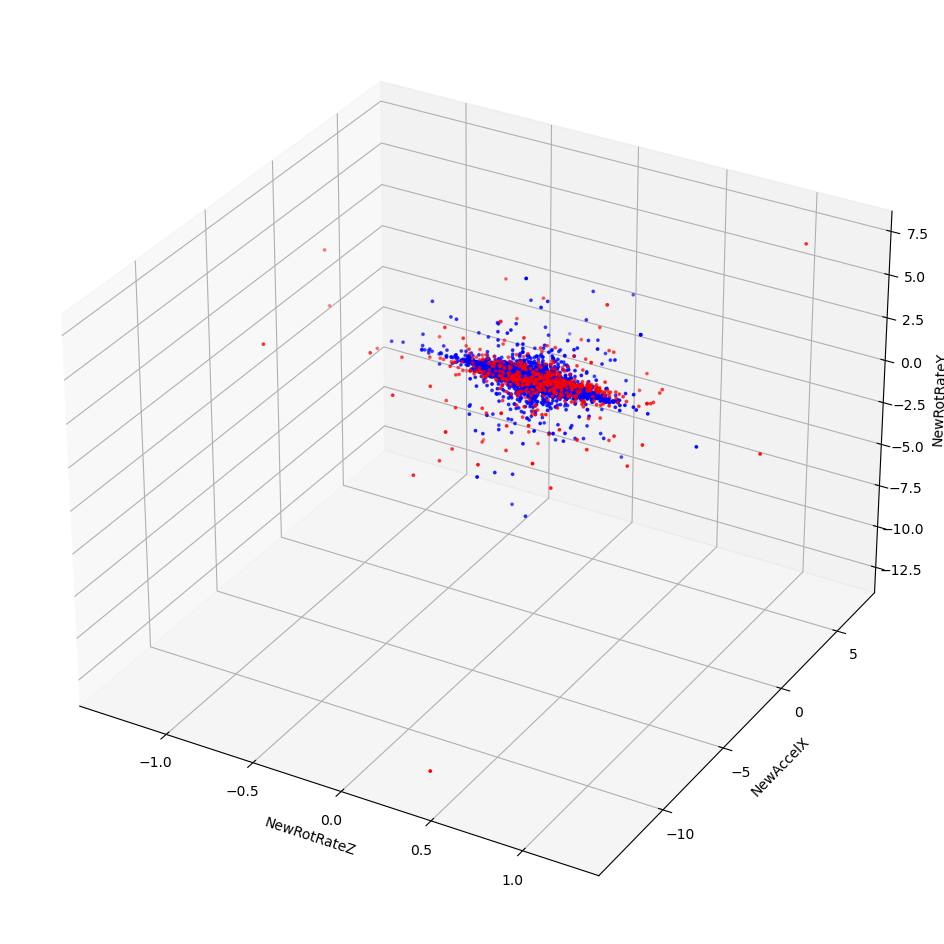

In [218]:
# create a new column with value 1 for outliers and 0 for the rest
df['isol_forest'] = final_outliers

# call the function for visualizing
outlier_vis('NewAccelX','NewRotRateZ', 'NewRotRateY', df, 'isol_forest')

print("Number of detected outliers:", df['isol_forest'].sum())

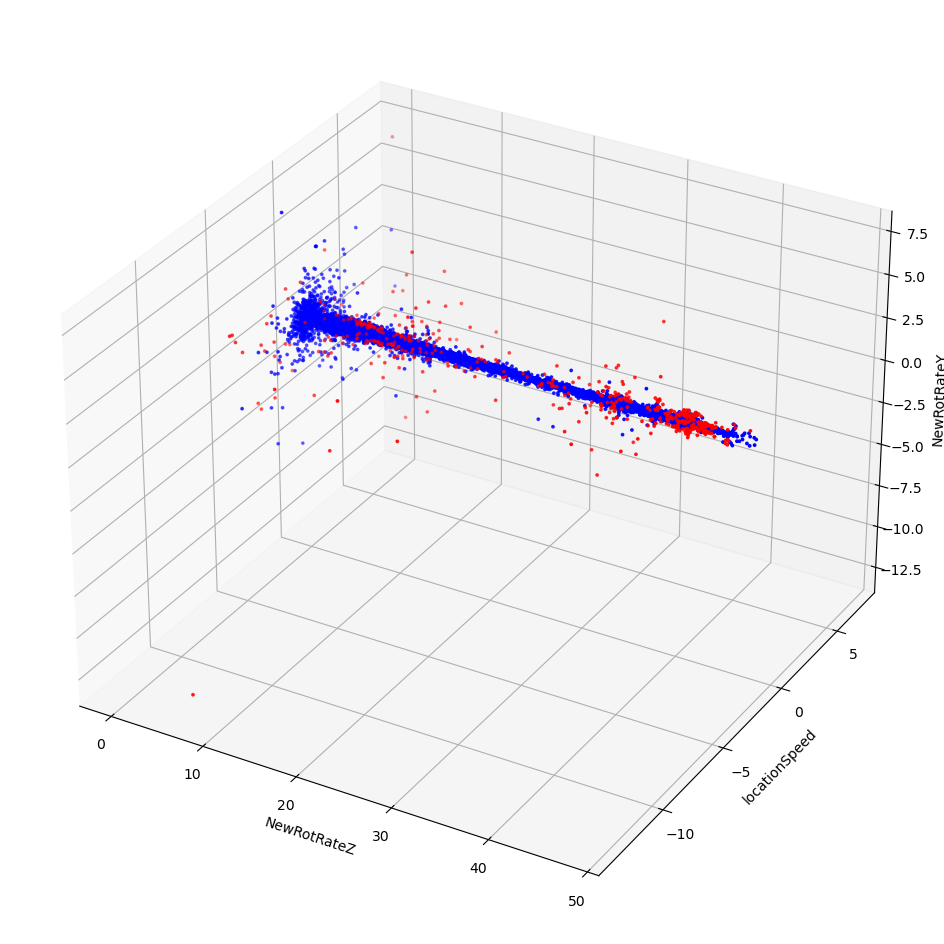

In [219]:
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df, 'isol_forest')


## Time series

### Variable: T

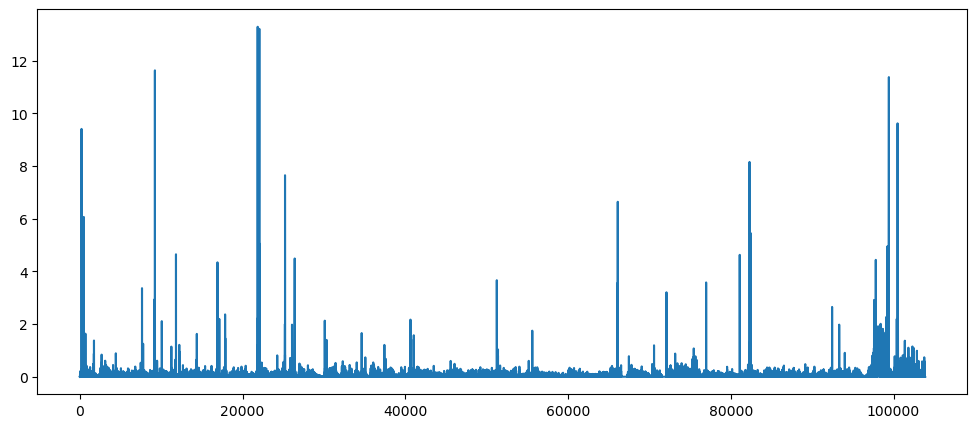

In [311]:
# visualize time-series for the selected variable

fig = plt.subplots(figsize=(12, 5))
plt.plot(df['T'])
plt.show()

In [319]:
from scipy.signal import find_peaks


# again assume about 0.5% of the dataset records to be outliers
min_distance = np.inf

for height in np.arange(0.05, 10, 0.05):
    # select height over which peak classified as outlier

    peaks_idxs, _ = find_peaks(df['T'], height=height, distance=20)  # arbitrary distance between neighboring peaks 

    # similarly to the other methods, we convert to 1 for outliers and 0 for the rest of the data
    outliers_found = len(peaks_idxs)

    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_peaks_idxs = peaks_idxs
        final_outliers = df.index.isin(peaks_idxs)
        final_height = height
    else:
        # since we traverse the height values sequentially from smaller to larger, we are increasing
        # the number of outliers in every iteration. Initially the distance is getting lower, until a point
        # where outliers increase over the 0.5% of the dataset records and we can exit the loop early for
        # better computational performance, skipping some iterations
        break

Number of detected outliers: 565


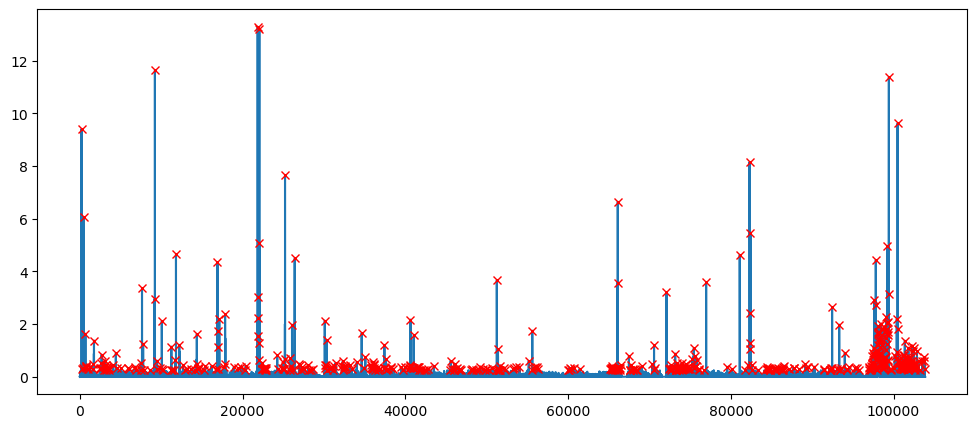

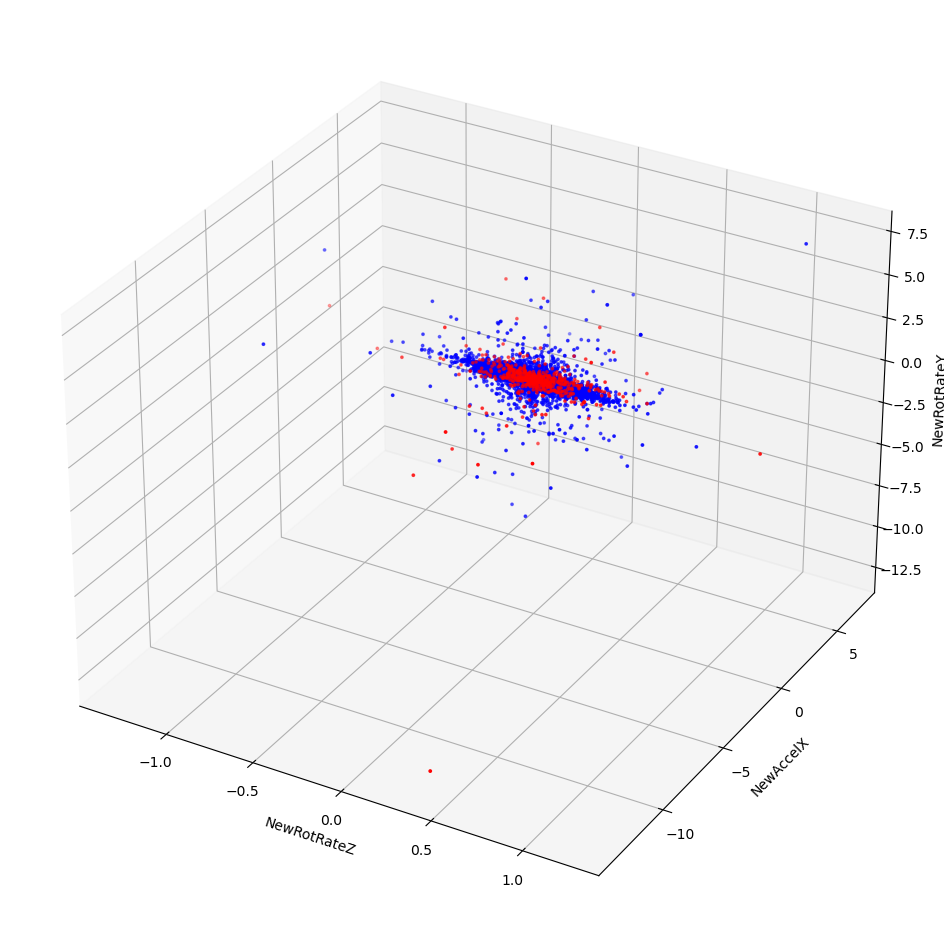

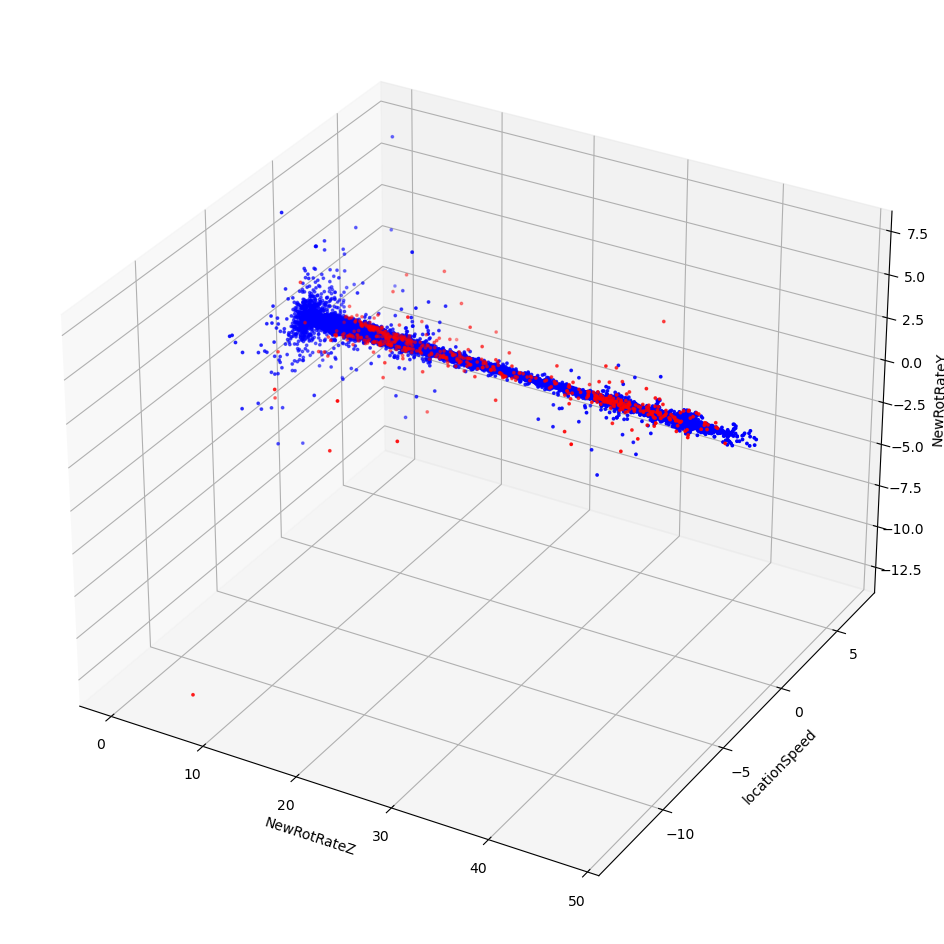

In [320]:
# create a new column with value 1 for outliers and 0 for the rest
df['time_series_peaks_T'] = final_outliers

print("Number of detected outliers:", df['time_series_peaks_T'].sum())

fig = plt.subplots(figsize=(12, 5))
plt.plot(df['T'])
plt.plot(final_peaks_idxs, df.loc[final_peaks_idxs, 'T'], "x", color='red')
plt.show()

# call the function for visualizing
outlier_vis('NewAccelX','NewRotRateZ', 'NewRotRateY', df, 'time_series_peaks_T')
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df, 'time_series_peaks_T')



### Variable: NewAccelX

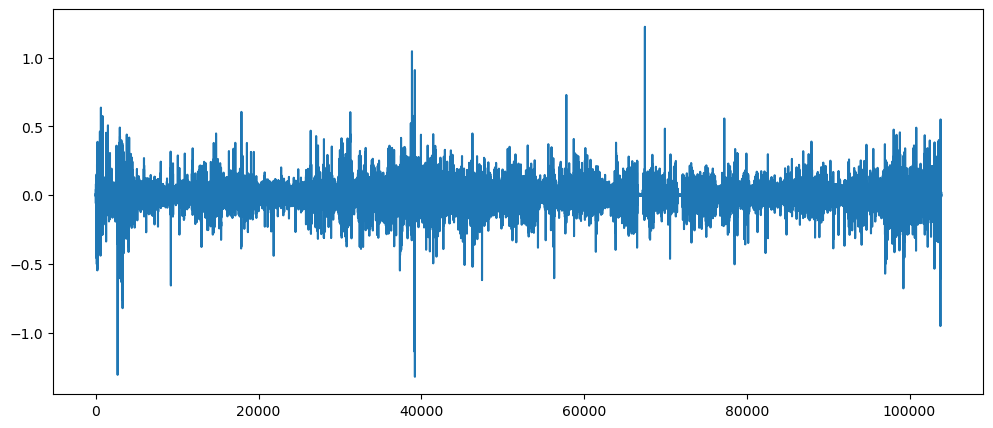

In [314]:
# visualize time-series for the selected variable

fig = plt.subplots(figsize=(12, 5))
plt.plot(df['NewAccelX'])
plt.show()

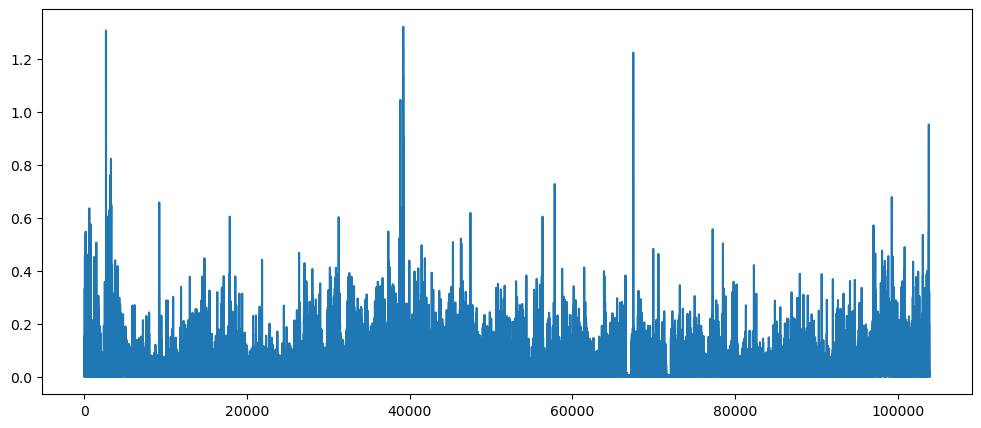

In [332]:
# plot the inverted negative ones

fig = plt.subplots(figsize=(12, 5))
plt.plot(np.abs(df['NewAccelX']))
plt.show()


In [330]:
from scipy.signal import find_peaks


# again assume about 0.5% of the dataset records to be outliers
min_distance = np.inf

for height in np.arange(0.01, 1, 0.01):
    # select height over which peak classified as outlier

    # since for NewAccelX we have negative and positive values, we take the absolute value
    # of the column to turn it to positive, and keep distance to None to allow for 
    # neighboring peaks to be possible (coming one from positive and another one from negative side)
    peaks_idxs, _ = find_peaks(np.abs(df['NewAccelX']), height=height, distance=None)  # arbitrary distance between neighboring peaks 

    # similarly to the other methods, we convert to 1 for outliers and 0 for the rest of the data
    outliers_found = len(peaks_idxs)

    if np.abs(outliers_found - outliers_number) <= min_distance:
        min_distance = np.abs(outliers_found - outliers_number)
        outliers_detected = outliers_found
        final_peaks_idxs = peaks_idxs
        final_outliers = df.index.isin(peaks_idxs)
        final_height = height
    else:
        # since we traverse the height values sequentially from smaller to larger, we are increasing
        # the number of outliers in every iteration. Initially the distance is getting lower, until a point
        # where outliers increase over the 0.5% of the dataset records and we can exit the loop early for
        # better computational performance, skipping some iterations
        break

Number of detected outliers: 521


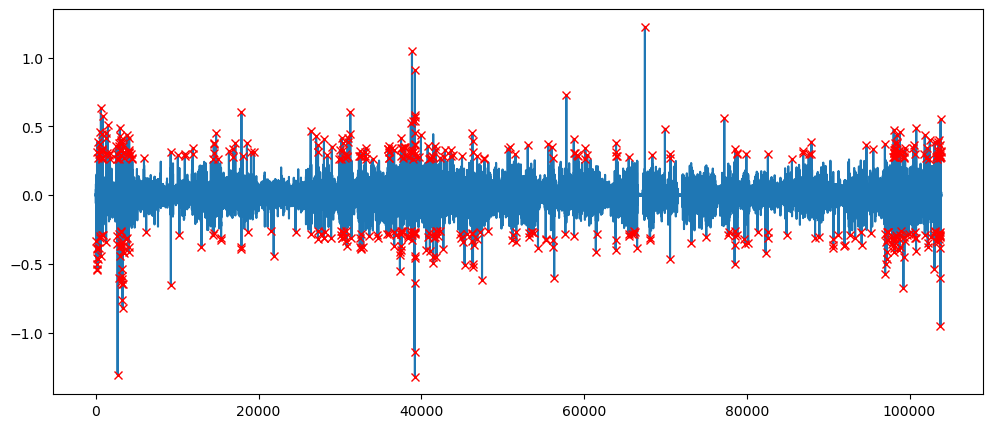

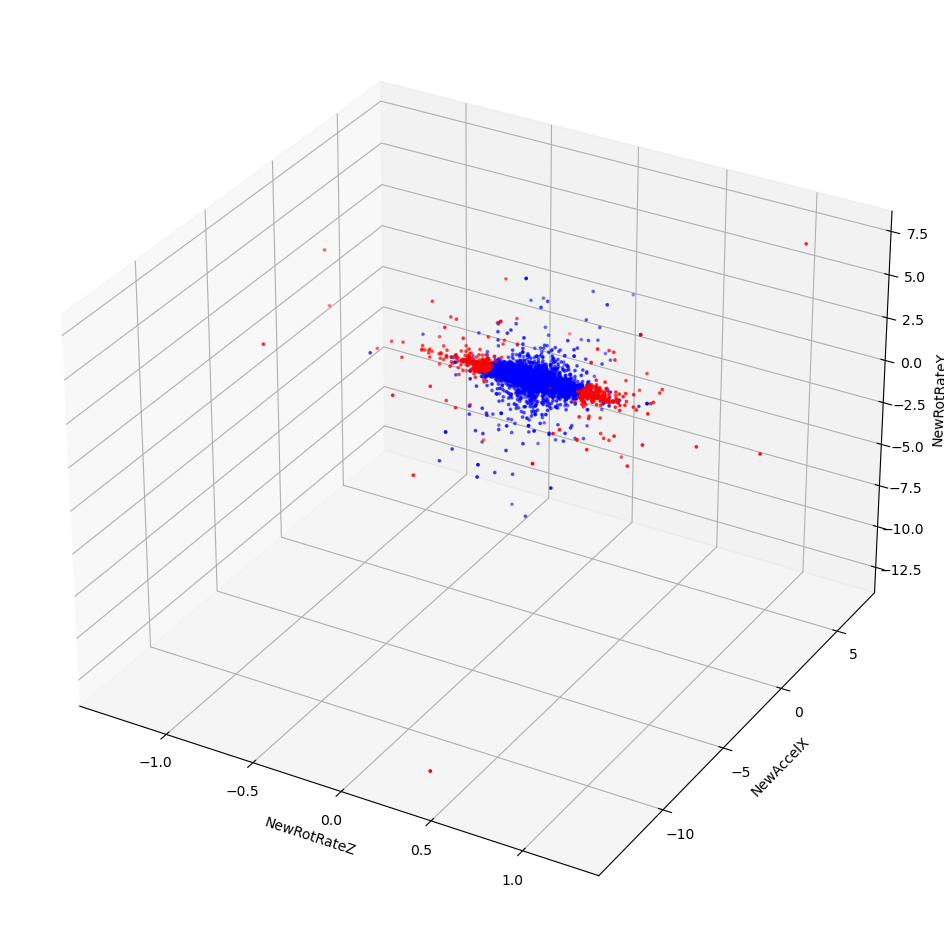

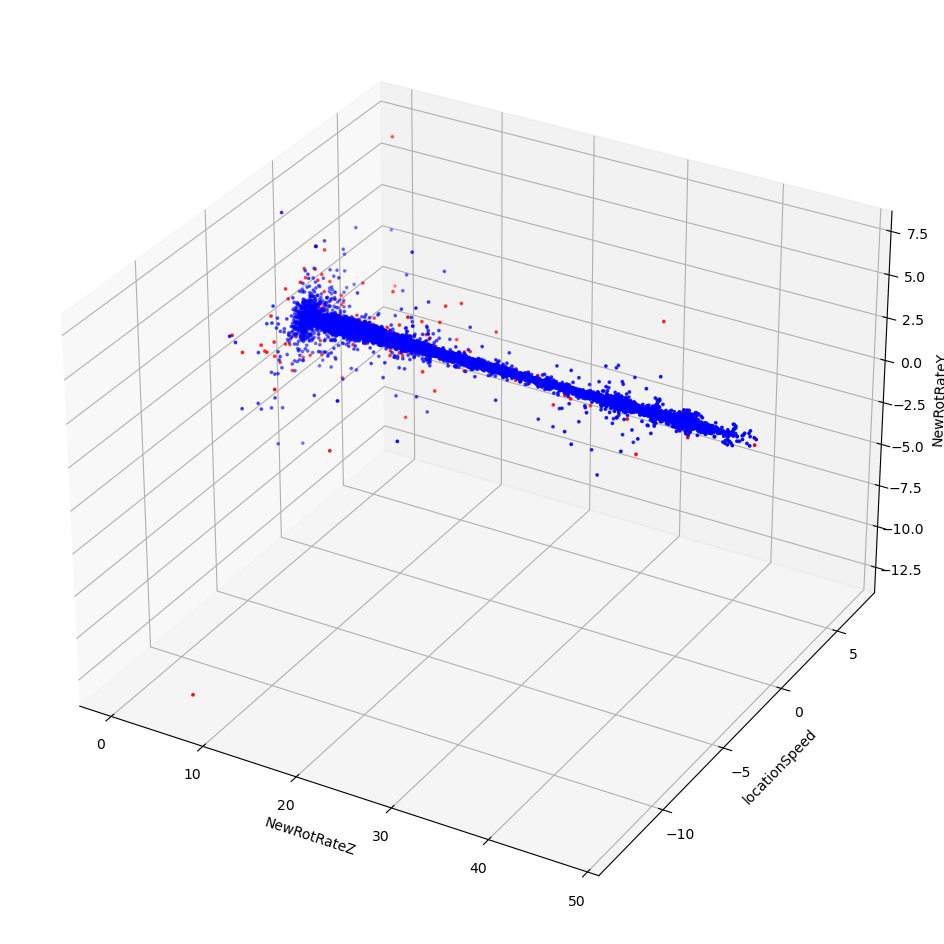

In [333]:
# create a new column with value 1 for outliers and 0 for the rest
df['time_series_peaks_NewAccelX'] = final_outliers

print("Number of detected outliers:", df['time_series_peaks_NewAccelX'].sum())

fig = plt.subplots(figsize=(12, 5))
plt.plot(df['NewAccelX'])
plt.plot(final_peaks_idxs, df.loc[final_peaks_idxs, 'NewAccelX'], "x", color='red')
plt.show()

# call the function for visualizing
outlier_vis('NewAccelX','NewRotRateZ', 'NewRotRateY', df, 'time_series_peaks_NewAccelX')
outlier_vis('locationSpeed','NewRotRateZ', 'NewRotRateY', df, 'time_series_peaks_NewAccelX')

# Summarize & compare findings

In [334]:
df

,NewAccelX,NewAccelY,NewAccelZ,NewRotRateX,NewRotRateY,NewRotRateZ,locationSpeed,T,bplot_T,bplot_NewAccelX,Z-score_T,zscore_T,Z-score_NewAccelX,zscore_NewAccelX,mean_dist_knn,knn,lof,isol_forest,time_series_peaks_T,time_series_peaks_NewAccelX
0,0.001,-0.002,-0.007,0.002,-0.001,0.000,0.0,0.000102,False,False,0.297934,False,0.018578,False,0.0,False,False,False,False,False
1,0.007,0.000,0.011,-0.001,0.001,0.000,0.0,0.000714,False,False,0.294169,False,0.121889,False,0.0,False,False,False,False,False
2,0.008,0.004,0.015,0.000,0.000,-0.001,0.0,0.000815,False,False,0.293541,False,0.139107,False,0.0,False,False,False,False,False
3,0.008,0.002,0.004,0.002,-0.001,-0.001,0.0,0.000815,False,False,0.293541,False,0.139107,False,0.0,False,False,False,False,False
4,0.009,0.001,0.026,-0.002,-0.001,0.002,0.0,0.000917,False,False,0.292913,False,0.156326,False,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103886,0.009,-0.001,-0.018,-0.022,0.011,0.004,0.0,0.000917,False,False,0.292913,False,0.156326,False,0.0,False,False,False,False,False
103887,-0.014,-0.067,-0.021,0.058,-0.048,-0.001,0.0,0.001427,False,False,0.289776,False,0.239698,False,0.0,False,False,False,False,False
103888,-0.005,0.022,-0.006,-0.003,0.022,0.001,0.0,0.000510,False,False,0.295424,False,0.084732,False,0.0,False,False,False,False,False
103889,0.022,-0.009,-0.003,-0.008,-0.006,0.003,0.0,0.002243,False,False,0.284755,False,0.380165,False,0.0,False,False,False,False,False


In [335]:
columns_map = {
    'Box Plot, T': 'bplot_T',
    'Box Plot, NewAccelX': 'bplot_NewAccelX',
    'Z-score, T': 'zscore_T',
    'Z-score, NewAccelX': 'zscore_NewAccelX',
    'kNN': 'knn',
    'LOF': 'lof',
    'Isolation Forest': 'isol_forest',
    'Time series, T': 'time_series_peaks_T',
    'Time series NewAccelX': 'time_series_peaks_NewAccelX'
}

In [343]:
df_preds = pd.DataFrame()
for k, v in columns_map.items():
    df_preds[k] = df[v]


In [345]:
df_preds

,"Box Plot, T","Box Plot, NewAccelX","Z-score, T","Z-score, NewAccelX",kNN,LOF,Isolation Forest,"Time series, T",Time series NewAccelX
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
103886,False,False,False,False,False,False,False,False,False
103887,False,False,False,False,False,False,False,False,False
103888,False,False,False,False,False,False,False,False,False
103889,False,False,False,False,False,False,False,False,False


In [351]:
print('Outliers Detected: ')
for k, v in columns_map.items():
    print(k, ':', df_preds[k].sum())

Outliers Detected: 
Box Plot, T : 11028
Box Plot, NewAccelX : 8655
Z-score, T : 514
Z-score, NewAccelX : 546
kNN : 535
LOF : 1866
Isolation Forest : 520
Time series, T : 565
Time series NewAccelX : 521


In [376]:
# we will now get the outliers that have been identified by each pair of methods
cols = df_preds.columns
target_dim = len(cols)

overlap = np.empty((target_dim, target_dim))

for i, column1 in enumerate(cols):
    for j, column2 in enumerate(cols):
        overlap[i, j] = (df_preds[column1] & df_preds[column2] ).sum()

df_overlap = pd.DataFrame(
    overlap,
    columns = cols,
    index = cols,
    dtype=int
)

df_overlap

,"Box Plot, T","Box Plot, NewAccelX","Z-score, T","Z-score, NewAccelX",kNN,LOF,Isolation Forest,"Time series, T",Time series NewAccelX
"Box Plot, T",11028,2391,514,230,384,140,499,565,207
"Box Plot, NewAccelX",2391,8655,218,546,385,158,351,267,521
"Z-score, T",514,218,514,39,202,72,356,116,40
"Z-score, NewAccelX",230,546,39,546,155,103,125,50,438
kNN,384,385,202,155,535,148,311,152,147
LOF,140,158,72,103,148,1866,111,54,95
Isolation Forest,499,351,356,125,311,111,520,165,115
"Time series, T",565,267,116,50,152,54,165,565,50
Time series NewAccelX,207,521,40,438,147,95,115,50,521


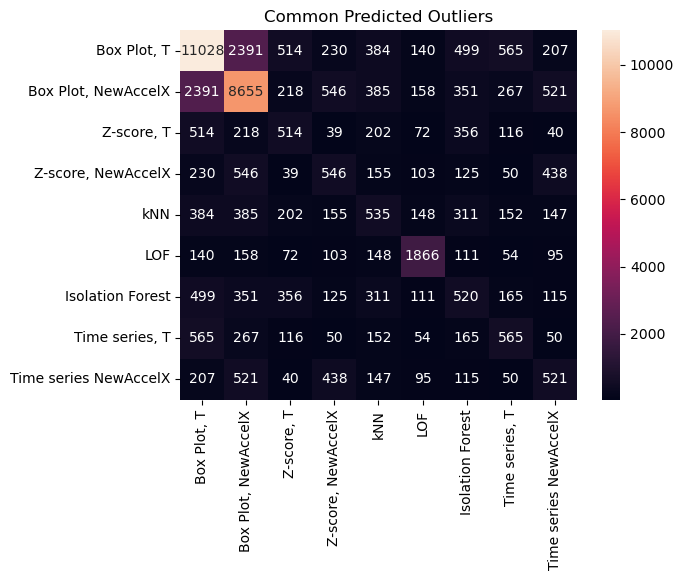

In [377]:
import seaborn as sns

# show heatmap of overlapping outliers detected by each method
ax = sns.heatmap(df_overlap, annot=True, fmt='d')
ax.set_title('Common Predicted Outliers')
plt.show()

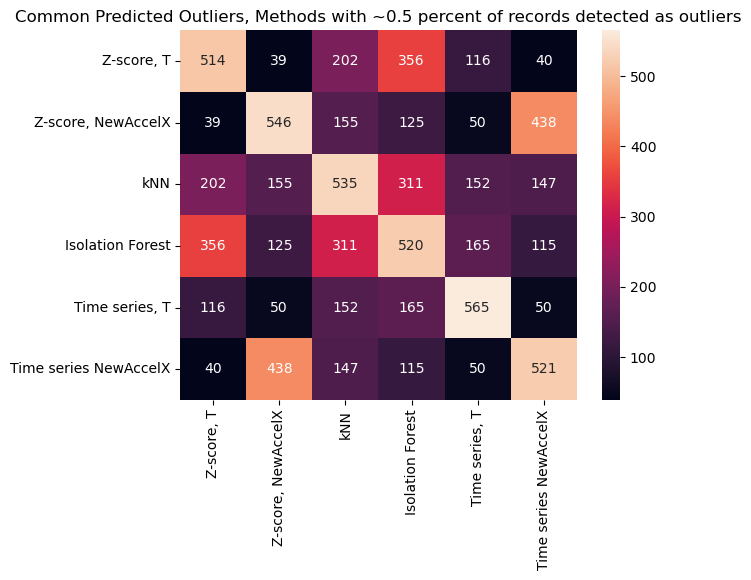

In [379]:
# next keep only the methods that yielded approximately 0.5% of the dataset records as outliers
df_overlap_2 = df_overlap.copy().drop(['Box Plot, T', 'Box Plot, NewAccelX', 'LOF'], axis=0)\
                                .drop(['Box Plot, T', 'Box Plot, NewAccelX', 'LOF'], axis=1)

# show heatmap of overlapping outliers detected by each method
ax = sns.heatmap(df_overlap_2, annot=True, fmt='d')
ax.set_title('Common Predicted Outliers, Methods with ~0.5 percent of records detected as outliers')
plt.show()

# Results export

In [380]:
df_preds.to_csv('predictions.csv', index=False)